In [1]:
%matplotlib inline
%config Completer.use_jedi=False

import lnPi
import lnPi.segment
import lnPi.stability
import numpy as np
import pandas as pd

In [2]:
# compare to this
df = pd.read_csv("./out.ljmix4_full.t080.v512.r1.lnpi_o.dat.const_mu.csv.gz").assign(
    lnz_0=lambda x: x["beta"] * x["mu_0"],
    lnz_1=lambda x: x["beta"] * x["mu_1"],
    betaOmega=lambda x: -x["beta"] * x["pressure"] * x["volume"],
)

In [3]:
path = "./ljmix4_full.t080.v512.r1.lnpi_o.dat.gz"
temp = 0.8
state_kws = {"temp": temp, "beta": 1.0 / temp, "volume": 512}
lnz = np.array([-2.5, -2.5])

In [4]:
# delayed
ref = lnPi.MaskedData.from_table(path, state_kws=state_kws, lnz=lnz).zeromax().pad()
phase_creator = lnPi.segment.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref, merge_kws=dict(efac=0.8)
)

In [5]:
# lnzs to consider
lnzs = df[["lnz_0", "lnz_1"]].values[:5]

array([[-10.   , -10.   ],
       [-10.   ,  -9.875],
       [-10.   ,  -9.75 ],
       [-10.   ,  -9.625],
       [-10.   ,  -9.5  ]])

In [7]:
# %%timeit -n 1 -r 1
with lnPi.set_options(
    tqdm_leave=True,
    joblib_use=True,
    joblib_len_build=20,
    tqdm_len_build=10,
    tqdm_bar="text",
):
    o = lnPi.MaskedDataCollection.from_builder(
        lnzs[:], phase_creator.build_phases, unstack=False
    )

In [8]:
def get_test_table(o, ref):
    return o.xge.table(
        keys=[
            "betaOmega",
            "nvec",
            "PE",
            "dens",
            "betaF",
            "S",
            "betaG",
            "edge_distance",
        ],
        ref=ref,
    )

In [9]:
get_test_table(o, ref).unstack("sample").to_dataframe().to_csv("data_0.csv")

In [43]:
import json

import lnPi.utils as utils

ds = utils.maskeddata_to_dataset(ref)
with open("ljmix_sup_example.json", "w") as f:
    json.dump(ds.to_dict(), f, indent=4)

In [10]:
with lnPi.set_options(tqdm_leave=True, tqdm_bar="text"):
    o.xge.pi_sum

In [37]:
o.xge.table(
    ["mask_stable", "dens", "betaOmega", "molfrac"], ref=ref, dim_to_suffix="component"
).unstack("sample").to_dataframe().head()

temp  beta  volume  edge_distance  mask_stable  \
lnz_0 lnz_1   phase                                                   
-10.0 -10.000 0       0.8  1.25     512     205.272989         True   
      -9.875  0       0.8  1.25     512     205.272989         True   
      -9.750  0       0.8  1.25     512     205.272989         True   
      -9.625  0       0.8  1.25     512     205.272989         True   
      -9.500  0       0.8  1.25     512     205.272989         True   

                     betaOmega    betapV    dens_0    dens_1  molfrac_0  \
lnz_0 lnz_1   phase                                                       
-10.0 -10.000 0      -0.035177  0.035177  0.000045  0.000023   0.660939   
      -9.875  0      -0.036766  0.036766  0.000045  0.000026   0.632385   
      -9.750  0      -0.038567  0.038567  0.000045  0.000030   0.602869   
      -9.625  0      -0.040607  0.040607  0.000045  0.000034   0.572585   
      -9.500  0      -0.042920  0.042920  0.000045  0.000038   0.541746   

                     molfrac_1    nvec_0    nvec_1  
lnz_0 lnz_1   phase                                 
-10.0 -10.000 0       0.339061  0.023262  0.011934  
      -9.875  0       0.367615  0.023264  0.013524  
      -9.750  0       0.397131  0.023265  0.015325  
      -9.625  0       0.427415  0.023267  0.017368  
      -9.500  0       0.458254  0.023268  0.019682

In [42]:
o.xge.table(
    ["mask_stable", "dens", "betaOmega", "molfrac"], ref=ref, dim_to_suffix="component"
)  # .unstack('sample').to_dataframe()

<xarray.Dataset>
Dimensions:        (sample: 5)
Coordinates:
  * sample         (sample) object MultiIndex
  * lnz_0          (sample) float64 -10.0 -10.0 -10.0 -10.0 -10.0
  * lnz_1          (sample) float64 -10.0 -9.875 -9.75 -9.625 -9.5
  * phase          (sample) int64 0 0 0 0 0
    temp           float64 0.8
    beta           float64 1.25
    volume         int64 512
Data variables:
    edge_distance  (sample) float64 205.3 205.3 205.3 205.3 205.3
    mask_stable    (sample) bool True True True True True
    betaOmega      (sample) float64 -0.03518 -0.03677 -0.03857 -0.04061 -0.04292
    betapV         (sample) float64 0.03518 0.03677 0.03857 0.04061 0.04292
    dens_0         (sample) float64 4.543e-05 4.544e-05 ... 4.544e-05 4.545e-05
    dens_1         (sample) float64 2.331e-05 2.641e-05 ... 3.392e-05 3.844e-05
    molfrac_0      (sample) float64 0.6609 0.6324 0.6029 0.5726 0.5417
    molfrac_1      (sample) float64 0.3391 0.3676 0.3971 0.4274 0.4583
    nvec_0         (sample) float64 0.02326 0.02326 0.02327 0.02327 0.02327
    nvec_1         (sample) float64 0.01193 0.01352 0.01533 0.01737 0.01968
Attributes:
    dims_n:      ['n_0', 'n_1']
    dims_lnz:    ['lnz_0', 'lnz_1']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'lnz_1', 'temp', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   distance from upper edge

In [11]:
# get data to compare
table = o.xge.table(
    ["mask_stable", "dens", "betaOmega", "molfrac"], ref=ref, dim_to_suffix="component"
)
t = table.to_dataframe().query("mask_stable").reset_index()

cols = [
    "lnz_0",
    "lnz_1",
    "beta",
    "betaOmega",
    "dens_0",
    "dens_1",
    "molfrac_0",
    "molfrac_1",
    "edge_distance",
]


def _round(df):
    return df.assign(
        lnz_0=lambda x: np.round(x.lnz_0, 3), lnz_1=lambda x: np.round(x.lnz_1, 3)
    )


a = t[cols].pipe(_round).set_index(["lnz_0", "lnz_1", "beta"])
b = (
    df.rename(columns=lambda x: x.replace("density", "dens"))[cols]
    .pipe(_round)
    .set_index(["lnz_0", "lnz_1", "beta"])
)

ValueError: cannot insert phase, already exists

In [13]:
t = table.to_dataframe()  # .query('mask_stable').reset_index()

In [24]:
table

<xarray.Dataset>
Dimensions:        (sample: 5)
Coordinates:
  * sample         (sample) object MultiIndex
  * lnz_0          (sample) float64 -10.0 -10.0 -10.0 -10.0 -10.0
  * lnz_1          (sample) float64 -10.0 -9.875 -9.75 -9.625 -9.5
  * phase          (sample) int64 0 0 0 0 0
    temp           float64 0.8
    beta           float64 1.25
    volume         int64 512
Data variables:
    edge_distance  (sample) float64 205.3 205.3 205.3 205.3 205.3
    mask_stable    (sample) bool True True True True True
    betaOmega      (sample) float64 -0.03518 -0.03677 -0.03857 -0.04061 -0.04292
    betapV         (sample) float64 0.03518 0.03677 0.03857 0.04061 0.04292
    dens_0         (sample) float64 4.543e-05 4.544e-05 ... 4.544e-05 4.545e-05
    dens_1         (sample) float64 2.331e-05 2.641e-05 ... 3.392e-05 3.844e-05
    molfrac_0      (sample) float64 0.6609 0.6324 0.6029 0.5726 0.5417
    molfrac_1      (sample) float64 0.3391 0.3676 0.3971 0.4274 0.4583
    nvec_0         (sample) float64 0.02326 0.02326 0.02327 0.02327 0.02327
    nvec_1         (sample) float64 0.01193 0.01352 0.01533 0.01737 0.01968
Attributes:
    dims_n:      ['n_0', 'n_1']
    dims_lnz:    ['lnz_0', 'lnz_1']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'lnz_1', 'temp', 'beta', 'volume']
    dims_rec:    ['sample']
    long_name:   distance from upper edge

In [10]:
np.abs((a - b) / a).max()

betaOmega        4.906069e-11
dens_0           4.684806e-11
dens_1           4.763309e-11
molfrac_0        4.500742e-11
molfrac_1        4.797235e-11
edge_distance    4.462730e-11
dtype: float64

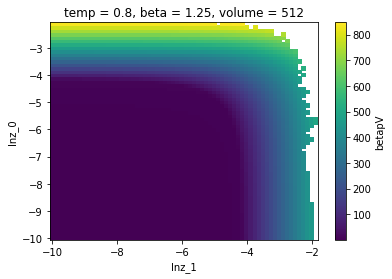

In [40]:
(table.betapV.where(table.mask_stable).dropna("sample").unstack().min("phase").plot())

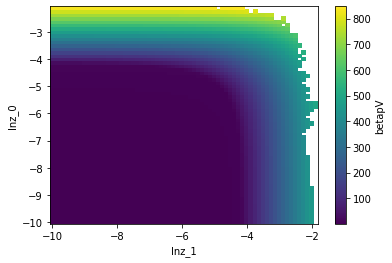

In [48]:
(
    df[["lnz_0", "lnz_1", "betaOmega"]]
    .set_index(["lnz_0", "lnz_1"])
    .assign(betapV=lambda x: -x["betaOmega"])["betapV"]
    .to_xarray()
    .plot()
)